In [1]:
%load_ext autoreload
%autoreload 1

In [10]:
import copy
import os
import time
from os import path as osp
import numpy as np
import torch
import yaml
from PIL import Image
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

from sacred import Experiment
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from tqdm.notebook import tqdm
from tracktor.config import get_output_dir
from tracktor.datasets.factory import Datasets
from tracktor.datasets.custom_wrapper import CustomSequence
from tracktor.frcnn_fpn import FRCNN_FPN
from tracktor.oracle_tracker import OracleTracker
from tracktor.reid.resnet import ReIDNetwork_resnet50
from tracktor.tracker import Tracker
from tracktor.utils import (evaluate_mot_accums, get_mot_accum,
                            interpolate_tracks, plot_sequence)
from torchvision.ops.boxes import clip_boxes_to_image, nms

In [11]:
def get_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = cv2.resize(img, (512, 512))
    return img

def hist_eq(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]

def print_img(img):
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap='Greys_r')
    
def draw_bounding(img, x1, x2, y1, y2, label):
    # draw a rectangle on the image
    h, w = img.shape[:2]
    cv2.putText(img, label , (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,255), 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)

In [12]:
from google.cloud import storage
PROJECT_NAME = "pluto-a31d9"
BUCKET_NAME = "pluto-tracking-samples"
client = storage.Client(project=PROJECT_NAME)
bucket = client.get_bucket(BUCKET_NAME)

groundtruth = bucket.get_blob("3_roads_faxe_gt_annotations.csv")
model_output = bucket.get_blob("3_roads_faxe_model_output.csv")

import csv
import pandas as pd
from io import StringIO, BytesIO
annotations_df = pd.read_csv(StringIO(groundtruth.download_as_string().decode("utf-8")))

# Image id is in model output file:
model_output_df = pd.read_csv(StringIO(model_output.download_as_string().decode("utf-8")))

annotations_df = annotations_df.merge(
    model_output_df[['image', 'image_id']].drop_duplicates(['image_id']),
    on='image_id'
)

# "CaptureId" column is expected, we can use the`image_id` as "proxy":
annotations_df["CaptureId"] = annotations_df['image_id']

img_ids = []
img_paths = []
for i, row in annotations_df.drop_duplicates(['image_id'], keep='first').iterrows():
    capture_id = row.image_id
    img_paths.append(f"testdata/images/{row.image}")
    img_ids.append(capture_id)

In [13]:
obj_detects = []
obj_detect_model = "../../output/custom/model_epoch_30.model"
obj_detect = FRCNN_FPN(num_classes=31)
obj_detect.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detects.append(obj_detect)
obj_detect.eval()
obj_detect.cuda();

tracker_conf = {
  "detection_person_thresh": 0.4,
  "regression_person_thresh": 0.001,
  "detection_nms_thresh": 0.05,
  "regression_nms_thresh": 0.5,
  "motion_model" : {
    "enabled": False,
    "n_steps": 5,
    "center_only": True
  },
  "public_detections": False,
  "do_align": False,
  "warp_mode": "MOTION_EUCLIDEAN",
  "number_of_iterations": 100,
  "termination_eps": 0.00001,
  "do_reid": False,
  "inactive_patience": 50,
  "max_features_num": 10,
  "reid_sim_threshold": 2.0,
  "reid_iou_threshold": 0.2
}

In [14]:
seq_name = 'bækvej_faxe'
img_dir = "../../data/" + seq_name
file_names = sorted(os.listdir(img_dir), key = lambda x: x[:4])
file_path = [img_dir  + "/" + name for name in file_names]

In [15]:
from tracktor.datasets.evaluation_wrapper import evaluationSequence
result_dir = "../../output/custom/results"
seq = evaluationSequence(seq_name, result_dir, annotations_df)

In [16]:
data_loader = DataLoader(seq, batch_size=1, shuffle=False)

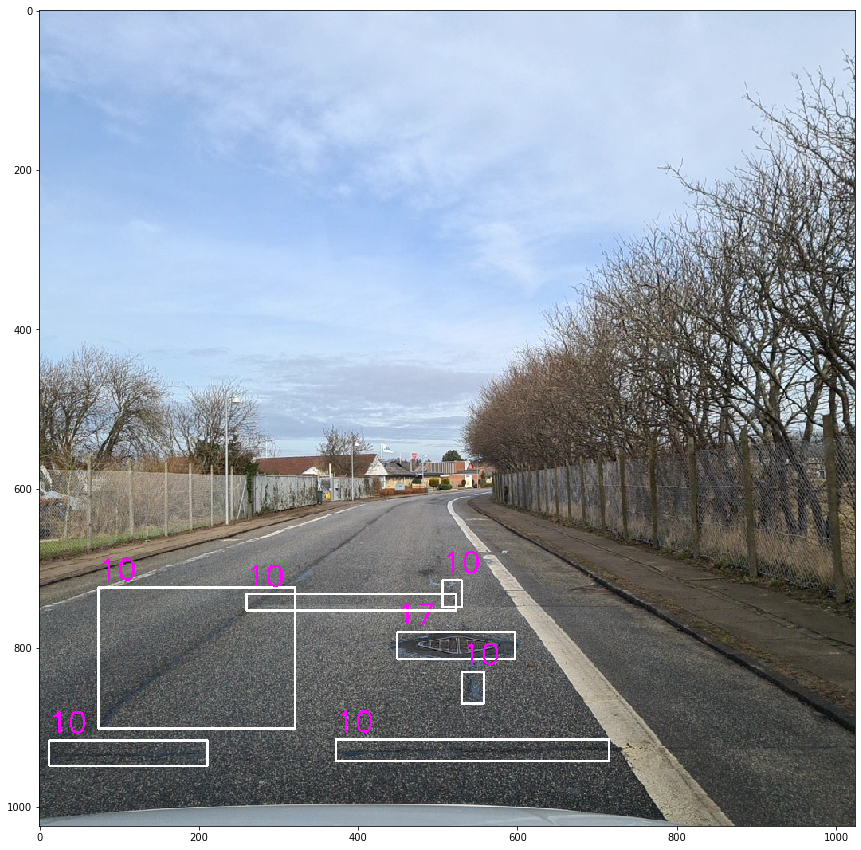

In [33]:
i = 220
transforms = ToTensor()
img = Image.open(file_path[i]).convert("RGB")
cv_img = get_img(file_path[i])
img_tensor = transforms(img).unsqueeze(0)
obj_detect.load_image(img_tensor)
boxes, labels, scores = obj_detect.detect(img_tensor, -1)
boxes = clip_boxes_to_image(boxes, img_tensor.shape[-2:])
keep = nms(boxes, scores, 0.1).cuda()
labels = labels.cpu().detach().numpy()
scores = scores.cpu().detach().numpy()
output_img = cv_img.copy()
for i in keep:
    box, label, score = boxes[i], labels[i], scores[i]
    if score > 0.2:
        draw_bounding(output_img, box[0], box[2], box[1], box[3], str(label))
print_img(output_img)

In [34]:
keep

tensor([ 0,  1,  2,  7,  8,  9, 12, 19, 33, 42], device='cuda:0')

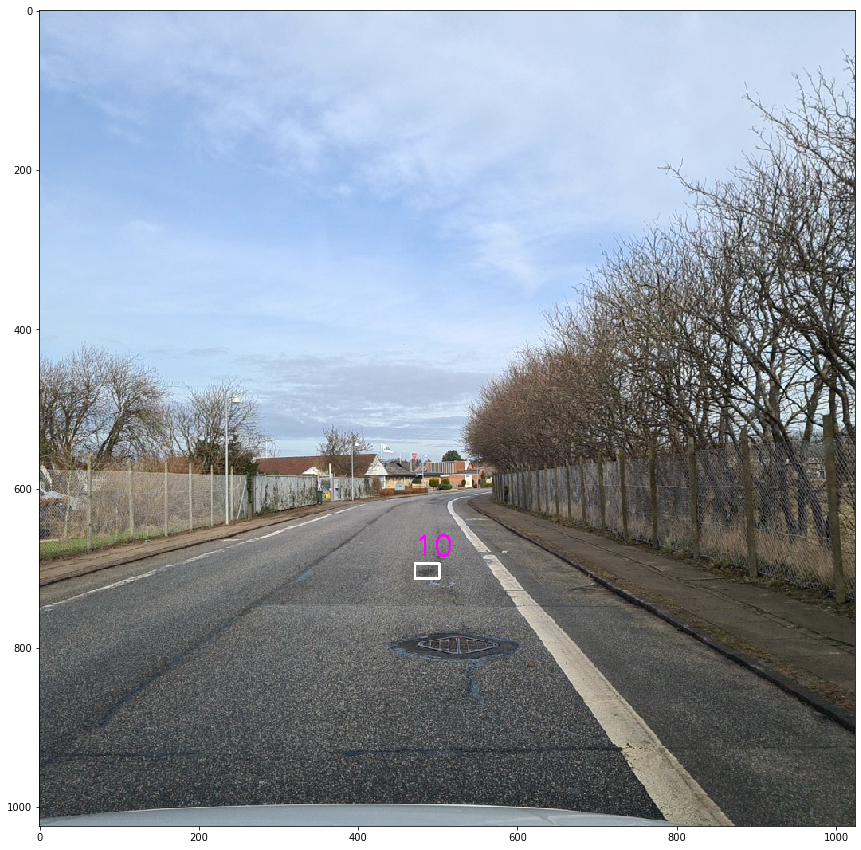

In [37]:
box, label, score = boxes[42], labels[42], scores[42]
output_img = cv_img.copy()
draw_bounding(output_img, box[0], box[2], box[1], box[3], str(label))
print_img(output_img)

In [217]:
box, label = box.unsqueeze(0), [label]

In [241]:
i += 1
img = Image.open(file_path[i]).convert("RGB")
cv_img = get_img(file_path[i])
img_tensor = transforms(img).unsqueeze(0)
obj_detect.load_image(img_tensor)
box, score = obj_detect.predict_boxes(box, label, -1)
box = clip_boxes_to_image(box, img_tensor.shape[-2:])

In [246]:
score.cpu()

tensor([0.5134])

In [265]:
det_boxes, det_labels, det_scores = obj_detect.detect(img_tensor, 16)

In [267]:
for i in range(del_labels[i]):
    det_box, det_label, det_score = det_boxes[i], det_labels[i], det_scores[i]
    det_boxes = clip_boxes_to_image(det_boxes, img_tensor.shape[-2:])
    if calculateIOU(box, det_box) > 0.6 and det_score > score:
        box, label, score = det_box, det_score
        box = box.unsqueeze(0)
        

tensor([0.9732, 0.7626, 0.7513, 0.6400, 0.5028, 0.4964, 0.4594, 0.4117, 0.4078,
        0.3849, 0.3108, 0.3093, 0.2982, 0.2744, 0.2725, 0.2438, 0.2346, 0.2342,
        0.2331, 0.2165, 0.2130, 0.2014, 0.1963, 0.1867, 0.1862, 0.1744, 0.1661,
        0.1656, 0.1624, 0.1577, 0.1563, 0.1519, 0.1515, 0.1467, 0.1408, 0.1399,
        0.1327, 0.1311, 0.1276, 0.1249, 0.1230, 0.1217, 0.1213, 0.1198, 0.1113,
        0.1111, 0.1076, 0.1054, 0.1043, 0.1034, 0.0987, 0.0979, 0.0973, 0.0952,
        0.0929, 0.0917, 0.0873, 0.0870, 0.0855, 0.0853, 0.0847, 0.0818, 0.0813,
        0.0803, 0.0800, 0.0789, 0.0785, 0.0775, 0.0763, 0.0739, 0.0710, 0.0699,
        0.0686, 0.0674, 0.0673, 0.0666, 0.0622, 0.0613, 0.0602, 0.0596, 0.0592,
        0.0555, 0.0553, 0.0547, 0.0546, 0.0530, 0.0529, 0.0515, 0.0509],
       device='cuda:0')

In [293]:
def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [297]:
bb_intersection_over_union((1,1,4,4), (5,5,6,6))

0

In [403]:
obj_detect_model = "../../output/custom/model_epoch_30.model"
obj_detect = FRCNN_FPN(num_classes=31)
obj_detect.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detect.eval()
obj_detect.cuda();

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
writer = cv2.VideoWriter("one_object.mp4", fourcc, 30, (1024, 1024), True)
i = 0
transforms = ToTensor()
img = Image.open(file_path[i]).convert("RGB")
cv_img = get_img(file_path[i])
img_tensor = transforms(img).unsqueeze(0)
obj_detect.load_image(img_tensor)
boxes, labels, scores = obj_detect.detect(img_tensor, -1)
boxes = clip_boxes_to_image(boxes, img_tensor.shape[-2:])
labels = labels.cpu().detach().numpy()
scores = scores.cpu().detach().numpy()
box, label, score = boxes[1], labels[1], scores[1]
box, label = box.unsqueeze(0), [label]
b, l = box[0], label[0]
output_img = cv_img.copy()
draw_bounding(output_img, b[0], b[2], b[1], b[3], str(l))
writer.write(output_img)
while i < len(file_path):
    i += 1
    img = Image.open(file_path[i]).convert("RGB")
    cv_img = get_img(file_path[i])
    img_tensor = transforms(img).unsqueeze(0)
    obj_detect.load_image(img_tensor)
    box, score = obj_detect.predict_boxes(box, label, -1)
    box = clip_boxes_to_image(box, img_tensor.shape[-2:])
    s = score.cpu().numpy()[0]

    
    det_boxes, det_labels, det_scores = obj_detect.detect(img_tensor, -1)
    det_boxes = clip_boxes_to_image(det_boxes, img_tensor.shape[-2:])
    det_labels = det_labels.cpu().detach().numpy()
    det_scores = det_scores.cpu().detach().numpy()
    for j in range(det_labels.shape[0]):
        det_box, det_label, det_score = det_boxes[j], det_labels[j], det_scores[j]
        if intersection_over_union(box[0], det_box) > 0.3 and det_score > score and det_score > 0.4 and det_label == label[0]:
            box, score = det_box, det_score
            box = box.unsqueeze(0)
            s = det_score
    
            
    b, l = box[0], label[0]
    output_img = cv_img.copy()
    draw_bounding(output_img, b[0], b[2], b[1], b[3], str(s))
    writer.write(output_img) 
    
    if s < 0.01:
        break
writer.release()

In [354]:
i += 1
img = Image.open(file_path[i]).convert("RGB")
cv_img = get_img(file_path[i])
img_tensor = transforms(img).unsqueeze(0)
obj_detect.load_image(img_tensor)
box, score = obj_detect.predict_boxes(box, label, -1)
box = clip_boxes_to_image(box, img_tensor.shape[-2:])

In [355]:
score

tensor([4.1361e-08], device='cuda:0')

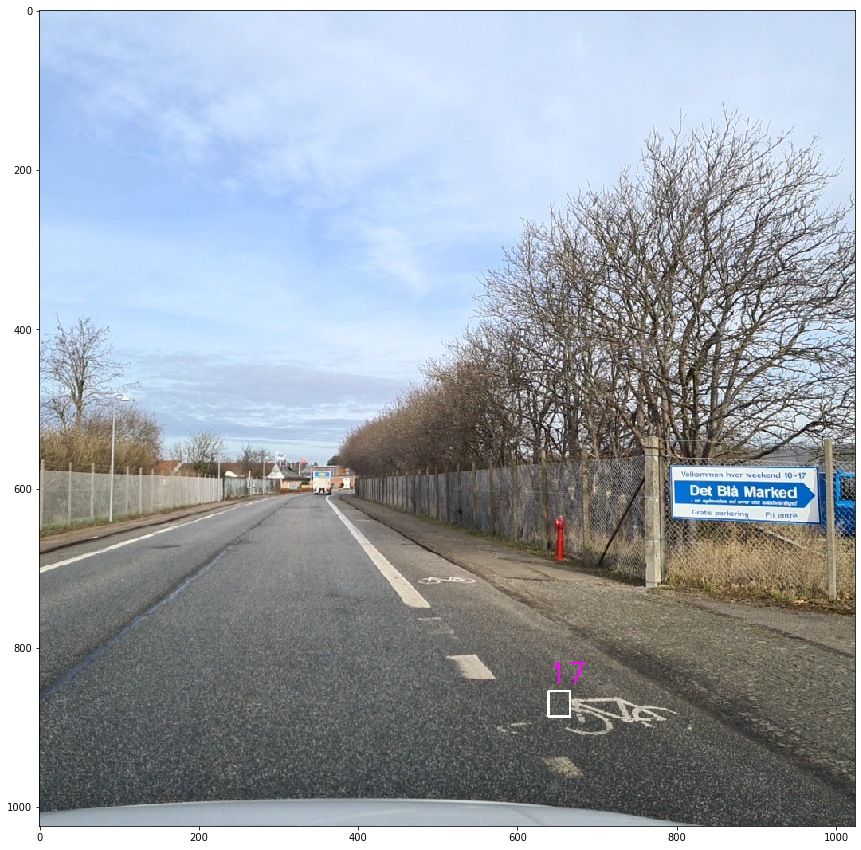

In [356]:
b, l = box[0], label[0]
output_img = cv_img.copy()
draw_bounding(output_img, b[0], b[2], b[1], b[3], str(l))
print_img(output_img)

In [363]:
def box_increase(box):
    box[0][0] -= 30
    box[0][1] -= 30
    box[0][2] += 30
    box[0][3] += 30